# 2. Topic Modeling - Latent Dirchlet Allocation (LDA) + time dimension

In [1]:
# format code
# pip install nb_black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [16]:
import pickle
import numpy as np
import pandas as pd
import re
import scipy.sparse
import gensim
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim import matutils
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

<IPython.core.display.Javascript object>

### comment condition:  >15words AND 10 unique words

In [3]:
stop_words = set(stopwords.words("german"))
stop_words_add = [
    "mal",
    "mehr",
    "ja",
    "schon",
    "gibt",
    "geht",
    "hast",
    "einfach",
    "ganz",
    "macht",
    "immer",
    "tun",
    "viele",
    "wer",
    "sagen",
    "wäre",
    "genau",
    "dafür",
    "natürlich",
    "seit",
    "wurde",
    "eigentlich",
    "kommt",
    "gesagt",
    "sagt",
    "nie",
    "sehen",
    "deren",
    "versuchen",
    "empfehlen",
    "müssen",
    "kurz",
    "wenig",
    "erste",
    "klare",
    "gar",
    "grad",
    "wohl",
    "oft",
    "ha",
    "schaffen",
    "daher",
    "schreibt",
    "ständig",
    "völlig",
    "verdient",
    "worden",
    "solange",
    "könnt",
    "mann",
    "zeigt",
    "später",
    "erste",
    "iwelche",
    "wen",
    "eigenem",
    "gründen",
    "ups",
    "irgendjemand",
    "wuerde",
    "gründen",
]
sw = set(list(stop_words) + stop_words_add)

<IPython.core.display.Javascript object>

In [4]:
corpora_names = [
    "2019-05",
    "2019-06",
    "2019-07",
    "2019-08",
    "2019-09",
    "2019-10",
    "2019-11",
    "2019-12",
    "2020-01",
    "2020-02",
    "2020-03",
    "2020-04",
    "2020-05",
    "2020-06",
    "2020-07",
    "2020-08",
    "2020-09",
    "2020-10",
    "2020-11",
    "2020-12",
    "2021-01",
    "2021-02",
    "2021-03",
    "2021-04",
    "2021-05",
    "2021-06",
    "2021-07",
    "2021-08",
]
corpora_docs = [
    131917,
    14823,
    2644,
    2395,
    1875,
    1167,
    1290,
    1370,
    1064,
    1136,
    1039,
    1567,
    1392,
    1859,
    1705,
    2102,
    1843,
    1976,
    2142,
    1510,
    3090,
    8059,
    9025,
    11319,
    6833,
    3285,
    9394,
    1727,
]
corpora_info = list(zip(corpora_names, corpora_docs))
print(corpora_info)

[('2019-05', 131917), ('2019-06', 14823), ('2019-07', 2644), ('2019-08', 2395), ('2019-09', 1875), ('2019-10', 1167), ('2019-11', 1290), ('2019-12', 1370), ('2020-01', 1064), ('2020-02', 1136), ('2020-03', 1039), ('2020-04', 1567), ('2020-05', 1392), ('2020-06', 1859), ('2020-07', 1705), ('2020-08', 2102), ('2020-09', 1843), ('2020-10', 1976), ('2020-11', 2142), ('2020-12', 1510), ('2021-01', 3090), ('2021-02', 8059), ('2021-03', 9025), ('2021-04', 11319), ('2021-05', 6833), ('2021-06', 3285), ('2021-07', 9394), ('2021-08', 1727)]


<IPython.core.display.Javascript object>

In [5]:
corpus = pd.read_pickle("data/pickle/corpus_clean.pkl")
corpus

,comment
0,feier sowas endlich jemand alten cdu stimme ni...
1,achtung faschisten irma lo beleidigt user ganz...
2,zeigt jahre jahre
3,doppelmoralist rezo eigenes video dezember pri...
4,richtig
...,...
229571,legalisierung mehr fahrverbote läuft
229572,j pepe leg fakten falsche informationen rausha...
229573,bundestag stehen abgeordnete mandat halten unt...
229574,liebe user lasst daran hindern frei meinung ek...


<IPython.core.display.Javascript object>

In [6]:
idx = 0
# idx_min = 0
# idx_max = corpus.shape[0]  # number of rows (documents in corpus)
corpus_d = {}

for i, t in enumerate(corpora_info):
    lb = idx
    rb = idx + t[1]

    corpus_d[t[0]] = {
        "len": t[1],
        "corpora": pd.DataFrame(data=corpus.iloc[lb:rb]),
    }
    assert corpus_d[t[0]]["len"] == corpus_d[t[0]]["corpora"].shape[0]
    idx += t[1] + 1

<IPython.core.display.Javascript object>

In [7]:
MIN_WORDS = 15
MIN_UNIQUE_WORDS = 10
progress = 0
print("")

for key, value in corpus_d.items():
    value["texts"] = []
    doc_to_drop = []

    for i in list(value["corpora"].index):
        progress += 1
        if len(value["corpora"].loc[i].comment.split()) < MIN_WORDS:
            doc_to_drop.append(i)
        elif len(set(value["corpora"].loc[i].comment.split())) < MIN_UNIQUE_WORDS:
            doc_to_drop.append(i)
        else:
            # (list of list of str) Tokenized texts, needed for coherence models
            value["texts"].append(value["corpora"].loc[i].comment.split())

        if progress % 100 == 0:
            print(f"progress: {progress}/{sum(corpora_docs)}", end="\r")

    value["corpora"] = value["corpora"].drop(index=doc_to_drop)

    d_ = {}
    for i, v in enumerate(list(value["corpora"].index)):
        d_[v] = i
    value["corpora"] = value["corpora"].rename(index=d_)

print("")


progress: 229500/229548


<IPython.core.display.Javascript object>

In [8]:
corpora_filtered_info = [
    (key, len(value["corpora"].index)) for key, value in corpus_d.items()
]
print(corpora_filtered_info)

[('2019-05', 50298), ('2019-06', 5416), ('2019-07', 826), ('2019-08', 745), ('2019-09', 591), ('2019-10', 360), ('2019-11', 412), ('2019-12', 445), ('2020-01', 357), ('2020-02', 361), ('2020-03', 375), ('2020-04', 502), ('2020-05', 421), ('2020-06', 600), ('2020-07', 544), ('2020-08', 618), ('2020-09', 581), ('2020-10', 634), ('2020-11', 663), ('2020-12', 468), ('2021-01', 893), ('2021-02', 2542), ('2021-03', 2876), ('2021-04', 3664), ('2021-05', 2138), ('2021-06', 1031), ('2021-07', 2986), ('2021-08', 541)]


<IPython.core.display.Javascript object>

In [20]:
docs_post_filtering = [x[1] for x in corpora_filtered_info]
print(f" docs per month (post filtering):\n {docs_post_filtering}")
print(f"\n nr docs (post filtering): {sum(docs_post_filtering)}")

 docs per month (post filtering):
 [50298, 5416, 826, 745, 591, 360, 412, 445, 357, 361, 375, 502, 421, 600, 544, 618, 581, 634, 663, 468, 893, 2542, 2876, 3664, 2138, 1031, 2986, 541]

 nr docs (post filtering): 81888


<IPython.core.display.Javascript object>

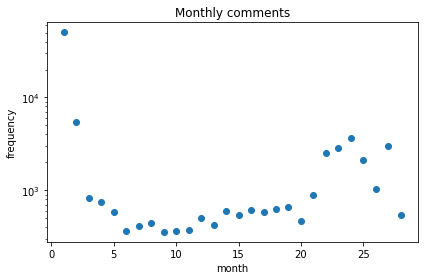

<IPython.core.display.Javascript object>

In [21]:
# scatterplot months
plt.scatter(range(1, len(docs_post_filtering) + 1), docs_post_filtering)
plt.title("Monthly comments")
plt.xlabel("month")
plt.ylabel("frequency")
plt.yscale("log")

plt.savefig("data/pdf/scatter_comments_post_filtering_tm_log.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [22]:
corpora_filtered_percentage = [
    (x[0][0], (round(1 - (x[0][1] / x[1][1]), 2)))
    for x in list(zip(corpora_filtered_info, corpora_info))
]
corpora_filtered_percentage

[('2019-05', 0.62),
 ('2019-06', 0.63),
 ('2019-07', 0.69),
 ('2019-08', 0.69),
 ('2019-09', 0.68),
 ('2019-10', 0.69),
 ('2019-11', 0.68),
 ('2019-12', 0.68),
 ('2020-01', 0.66),
 ('2020-02', 0.68),
 ('2020-03', 0.64),
 ('2020-04', 0.68),
 ('2020-05', 0.7),
 ('2020-06', 0.68),
 ('2020-07', 0.68),
 ('2020-08', 0.71),
 ('2020-09', 0.68),
 ('2020-10', 0.68),
 ('2020-11', 0.69),
 ('2020-12', 0.69),
 ('2021-01', 0.71),
 ('2021-02', 0.68),
 ('2021-03', 0.68),
 ('2021-04', 0.68),
 ('2021-05', 0.69),
 ('2021-06', 0.69),
 ('2021-07', 0.68),
 ('2021-08', 0.69)]

<IPython.core.display.Javascript object>

In [42]:
corpora_filtered_documents_f = [x[1] for x in corpora_filtered_info]
corpora_filtered_documents_sum = sum(corpora_filtered_documents_f)
corpora_filtered_documents_min = min(corpora_filtered_documents_f)
corpora_filtered_documents_max = max(corpora_filtered_documents_f)
corpora_filtered_documents_mean = np.mean(corpora_filtered_documents_f)
corpora_filtered_documents_median = np.median(corpora_filtered_documents_f)
print(f"sum docs: {corpora_filtered_documents_sum}")
print("")
print(f"min docs: {corpora_filtered_documents_min}")
print(f"max docs: {corpora_filtered_documents_max}")
print("")
print(f"mean docs: {corpora_filtered_documents_mean}")
print(f"median docs: {corpora_filtered_documents_median}")

sum docs: 81888

min docs: 357
max docs: 50298

mean docs: 2924.5714285714284
median docs: 609.0


<IPython.core.display.Javascript object>

In [24]:
for key, value in corpus_d.items():
    value["tfidf_vectorizer"] = TfidfVectorizer(stop_words=sw)
    value["tfidf_wm"] = value["tfidf_vectorizer"].fit_transform(
        value["corpora"].comment
    )
    value["tfidf"] = pd.DataFrame(
        value["tfidf_wm"].toarray(),
        columns=value["tfidf_vectorizer"].get_feature_names(),
    )
    value["tfidf"].index = value["corpora"].index
    value["tfidf"] = value["tfidf"].transpose()

<IPython.core.display.Javascript object>

In [25]:
for key, value in corpus_d.items():
    value["dictionary"] = Dictionary(value["texts"])
    value["sparse_counts"] = scipy.sparse.csr_matrix(value["tfidf"])
    value["corpus_sparse"] = matutils.Sparse2Corpus(value["sparse_counts"])
    value["id2word"] = dict(
        (v, k) for k, v in value["tfidf_vectorizer"].vocabulary_.items()
    )

<IPython.core.display.Javascript object>

###  evaluate number of topics for each month

In [26]:
start = 4
limit = 20
step = 2
print("")

for key, value in corpus_d.items():
    value["lda_models"] = []
    print(f"processing: {key}", end="\r")

    for num_topics in range(start, limit, step):
        # list of tuple of model,coherence
        lda_model = models.LdaModel(
            corpus=value["corpus_sparse"],
            id2word=value["id2word"],
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            passes=10,
            alpha="auto",
        )
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=value["texts"],
            dictionary=value["dictionary"],
        )
        value["lda_models"].append((lda_model, coherence_model.get_coherence()))

print("")


processing: 2021-08


<IPython.core.display.Javascript object>

In [27]:
for key, value in corpus_d.items():
    print(f"## {key}")
    lda_coherence_values = [x[1] for x in value["lda_models"]]
    num_topics_lda = list(range(4, 20, 2))

    assert len(num_topics_lda) == len(lda_coherence_values)

    print(list(zip([str(x) + " Topics" for x in num_topics_lda], lda_coherence_values)))
    print("\n\n")

## 2019-05
[('4 Topics', 0.7784599159828105), ('6 Topics', 0.7624027296574655), ('8 Topics', 0.7538501407716326), ('10 Topics', 0.7482827332737104), ('12 Topics', 0.7567082498102687), ('14 Topics', 0.7422013578009288), ('16 Topics', 0.7409633593788693), ('18 Topics', 0.7369976727135255)]



## 2019-06
[('4 Topics', 0.755400552579629), ('6 Topics', 0.7604638355505572), ('8 Topics', 0.7639319848363995), ('10 Topics', 0.7539145784465456), ('12 Topics', 0.7595723058034989), ('14 Topics', 0.7644022868554898), ('16 Topics', 0.7529547631068527), ('18 Topics', 0.7625133466710894)]



## 2019-07
[('4 Topics', 0.7824250061371096), ('6 Topics', 0.7747290541847268), ('8 Topics', 0.7718374638167718), ('10 Topics', 0.7703084361414156), ('12 Topics', 0.7756480296626996), ('14 Topics', 0.7686225239844734), ('16 Topics', 0.7649623466467275), ('18 Topics', 0.7676424669556547)]



## 2019-08
[('4 Topics', 0.807343283587483), ('6 Topics', 0.8014740802944673), ('8 Topics', 0.8026387157876548), ('10 Topics'

<IPython.core.display.Javascript object>

In [118]:
# get best' 28 models out of 224 (28 months, each 8 lda models (4,6,8,10,12,14,16,18 topics))
num_topics_max_coherence = []

for key, value in corpus_d.items():
    max_coherence = max([x[1] for x in value["lda_models"]])
    nr_topics = None
    for i, t in enumerate(value["lda_models"]):
        if t[1] == max_coherence:
            nr_topics = 4 + 2 * i
    num_topics_max_coherence.append((key, nr_topics, max_coherence))

assert len(num_topics_max_coherence) == 28
print(f"nr topics with max coherence per month: \n")
for t in num_topics_max_coherence:
    print(f"{t[0]}  %2s  {t[2]}" % t[1])

nr topics with max coherence per month: 

2019-05   4  0.7784599159828105
2019-06  14  0.7644022868554898
2019-07   4  0.7824250061371096
2019-08   4  0.807343283587483
2019-09   6  0.789107812352575
2019-10   4  0.7980452858167555
2019-11   4  0.795320930933233
2019-12   8  0.8040753880855329
2020-01   4  0.8016539059701929
2020-02   4  0.8233715951489471
2020-03  14  0.7868903610697586
2020-04   4  0.8006558791067662
2020-05  10  0.7885925353560453
2020-06   4  0.8064575583529004
2020-07  14  0.784859127773749
2020-08   4  0.8112649674960417
2020-09  10  0.8069997197974954
2020-10  14  0.7770155666565027
2020-11   6  0.7948259473277961
2020-12   4  0.812529080172667
2021-01   4  0.8036756093680203
2021-02  16  0.7790533694895352
2021-03   6  0.7821998843415966
2021-04   6  0.774933521464221
2021-05   4  0.8000039601760731
2021-06   4  0.820006524537575
2021-07   4  0.7697345315812782
2021-08   6  0.794818149324653


<IPython.core.display.Javascript object>

In [119]:
print(f"nr topics mean: {np.mean([x[1] for x in num_topics_max_coherence])}")
print(f"nr topics median: {np.median([x[1] for x in num_topics_max_coherence])}")

nr topics mean: 6.785714285714286
nr topics median: 4.0


<IPython.core.display.Javascript object>

### trimm to (best) equal number of topics

In [112]:
print(f"pre coherence mean: {np.mean([x[2] for x in num_topics_max_coherence])}")
print(f"pre coherence median: {np.median([x[2] for x in num_topics_max_coherence])}")

pre coherence mean: 0.7942400608665288
pre coherence median: 0.7950734391305145


<IPython.core.display.Javascript object>

In [132]:
d_lda_model_stats_equal_nr_topics = {}

for nr_topics_for_model in range(start, limit, step):
    topic_idx = int((nr_topics_for_model - 4) / 2)
    for i, (key, value) in enumerate(corpus_d.items()):
        if nr_topics_for_model not in d_lda_model_stats_equal_nr_topics:
            d_lda_model_stats_equal_nr_topics[nr_topics_for_model] = []
        d_lda_model_stats_equal_nr_topics[nr_topics_for_model].append(
            (
                key,
                nr_topics_for_model,
                value["lda_models"][topic_idx][1],
            )
        )
    assert len(d_lda_model_stats_equal_nr_topics[nr_topics_for_model]) == 28

num_topics_mean_coherence = []

for key, value in d_lda_model_stats_equal_nr_topics.items():
    coherence_values = [x[2] for x in value]
    num_topics_mean_coherence.append((key, np.mean(coherence_values)))

num_topics_mean_coherence.sort(key=lambda t: t[1], reverse=True)
print(num_topics_mean_coherence)

[(4, 0.7903075456873623), (6, 0.7856142370844115), (8, 0.783418480180378), (10, 0.7815146313005118), (12, 0.7806564044427399), (14, 0.7802279984189354), (16, 0.7786046998804508), (18, 0.7773245150017184)]


<IPython.core.display.Javascript object>

In [133]:
# choose best coherence mean for equal number of topics
optimal_eq_num_topics = d_lda_model_stats_equal_nr_topics[
    num_topics_mean_coherence[0][0]
]

<IPython.core.display.Javascript object>

In [134]:
print(f"post coherence mean: {np.mean([x[2] for x in optimal_eq_num_topics])}")
print(f"post coherence median: {np.median([x[2] for x in optimal_eq_num_topics])}")

post coherence mean: 0.7903075456873623
post coherence median: 0.7929770836924763


<IPython.core.display.Javascript object>

In [135]:
optimal_eq_num_topics

[('2019-05', 4, 0.7784599159828105),
 ('2019-06', 4, 0.755400552579629),
 ('2019-07', 4, 0.7824250061371096),
 ('2019-08', 4, 0.807343283587483),
 ('2019-09', 4, 0.7741906438213518),
 ('2019-10', 4, 0.7980452858167555),
 ('2019-11', 4, 0.795320930933233),
 ('2019-12', 4, 0.7934091544971216),
 ('2020-01', 4, 0.8016539059701929),
 ('2020-02', 4, 0.8233715951489471),
 ('2020-03', 4, 0.7616859840430491),
 ('2020-04', 4, 0.8006558791067662),
 ('2020-05', 4, 0.7826140011823469),
 ('2020-06', 4, 0.8064575583529004),
 ('2020-07', 4, 0.7827968245468819),
 ('2020-08', 4, 0.8112649674960417),
 ('2020-09', 4, 0.8056557414738404),
 ('2020-10', 4, 0.7660626292343244),
 ('2020-11', 4, 0.7823927745973234),
 ('2020-12', 4, 0.812529080172667),
 ('2021-01', 4, 0.8036756093680203),
 ('2021-02', 4, 0.7758654980040327),
 ('2021-03', 4, 0.7789171872747761),
 ('2021-04', 4, 0.7661272407357788),
 ('2021-05', 4, 0.8000039601760731),
 ('2021-06', 4, 0.820006524537575),
 ('2021-07', 4, 0.7697345315812782),
 ('202

<IPython.core.display.Javascript object>

### inteprete: top 10 keywords -> topic

In [136]:
nr_words = 10


def get_topics_format(topics):
    topics_words = []
    for topic in topics:
        s = topic[1].split("+")
        s = [tuple(x.split("*")) for x in s]
        weights = [float(x[0]) for x in s]
        words = [x[1].replace('"', "") for x in s]
        topics_words.append(list(zip(words, weights)))
    return topics_words


for idx, (key, value) in enumerate(corpus_d.items()):
    nr_t = optimal_eq_num_topics[idx][1]
    lda_index = int((nr_t - 4) / 2)
    coherence_value = value["lda_models"][lda_index][1]
    print(f"## {key} | {nr_t} Topics | coherence {coherence_value}\n")

    for i, topic_words in enumerate(
        get_topics_format(
            value["lda_models"][lda_index][0].print_topics(num_words=nr_words)
        )
    ):
        weights_mean = round(sum([x[1] for x in topic_words]) / nr_words, 4)
        print(f"### Topic: {i+1} | weights_mean: {weights_mean}")
        print(topic_words, "\n")
    print("\n\n")

## 2019-05 | 4 Topics | coherence 0.7784599159828105

### Topic: 1 | weights_mean: 0.0142
[('zitat ', 0.022), ('grünen ', 0.018), ('beleidigen ', 0.014), ('lügen ', 0.014), ('linker ', 0.014), ('unterstellen ', 0.012), ('striegel ', 0.012), ('volkstod ', 0.012), ('sebastian ', 0.012), ('zuwanderung', 0.012)] 

### Topic: 2 | weights_mean: 0.0137
[('maniac ', 0.017), ('lügen ', 0.017), ('unterstellungen ', 0.016), ('beleidigungen ', 0.015), ('gollum ', 0.014), ('cordes ', 0.013), ('axel ', 0.013), ('stefan ', 0.011), ('faschisten ', 0.011), ('lo', 0.01)] 

### Topic: 3 | weights_mean: 0.0038
[('video ', 0.007), ('cdu ', 0.005), ('afd ', 0.005), ('wählen ', 0.003), ('politik ', 0.003), ('rezo ', 0.003), ('partei ', 0.003), ('gut ', 0.003), ('menschen ', 0.003), ('danke', 0.003)] 

### Topic: 4 | weights_mean: 0.019
[('coronaregeln ', 0.019), ('abstandsregeln ', 0.019), ('couch ', 0.019), ('geltenden ', 0.019), ('maskenpflicht ', 0.019), ('gespielt ', 0.019), ('privat ', 0.019), ('eingeha

<IPython.core.display.Javascript object>